In [1]:

import os
import pandas as pd
import torch
from itertools import product
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading



from itertools import product
from datasets import load_dataset,load_from_disk
import config
import os
import pandas as pd
import util
import torch
import plotting


stats = []
stats_lock = threading.Lock()

all_combinations = [
    (d + "_" + t + "_random", d, t, c)
    for d, t, c in product(config.datasets, config.model_types, config.baseline_curricula)
]

def process_combination(combination):
    model_name, dataset_name, model_type, curriculum_name = combination
    local_stats = []
    try:
        influence_output_dir = os.path.join(
            "./influence_mean_normalized",
            os.path.basename(model_name),
            "_".join([(os.path.basename(dataset_name) + "_" + "train[0%:100%]")] * 2),
        )

        dataset = load_dataset(dataset_name)["train"]
        curriculum = util.get_curriculum(dataset_name, curriculum_name)

        # Load data into DataFrame
        df = pd.DataFrame({
            int(result_checkpoint.replace("checkpoint-", "")): torch.load(
                os.path.join(influence_output_dir, result_checkpoint),
                weights_only=True,
                map_location="cpu"
            ).numpy().flatten()
            for result_checkpoint in os.listdir(influence_output_dir)
        })
        df = df.reindex(sorted(df.columns), axis=1)
        df["total"] = df.sum(axis=1)
        df[["text", "source", "stage"]] = dataset.to_pandas()
        df["document_lenght"] = df["text"].str.split().str.len()

        def add_stat(counts, words, curriculum_label, epoch):
            c = pd.DataFrame(counts, columns=["counts"]).join(words)
            c["model_name"] = model_name
            c["dataset_name"] = dataset_name
            c["model_type"] = model_type
            c["curriculum_name"] = curriculum_label
            c["epoch"] = epoch
            local_stats.append(c)

        for i in range(len(curriculum)):
            counts_random = df.iloc[curriculum[i]].groupby("stage").size()
            words_random = df.iloc[curriculum[i]].groupby("stage")["document_lenght"].sum()
            add_stat(counts_random, words_random, curriculum_name, i)

            for influence_curriculum_name in config.influence_curricula:
                full_curriculum_name = model_type + influence_curriculum_name
                influence_curriculum = util.get_curriculum(dataset_name, full_curriculum_name)

                counts_influence_curriculum = df.iloc[influence_curriculum[i]].groupby("stage").size()
                words_influence_curriculum = df.iloc[influence_curriculum[i]].groupby("stage")["document_lenght"].sum()
                add_stat(counts_influence_curriculum, words_influence_curriculum, full_curriculum_name, i)

    except Exception as e:
        print(f"Skipping {model_name}, {dataset_name}, {model_type}, {curriculum_name}")
        print("Reason:", str(e))

    with stats_lock:
        stats.extend(local_stats)

with ThreadPoolExecutor(max_workers=32) as executor:
    futures = [executor.submit(process_combination, c) for c in all_combinations]
    for _ in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        pass


stats_df = pd.concat(stats).reset_index()


Processing:   4%|▍         | 1/24 [00:02<01:05,  2.84s/it]

Skipping loris3/stratified_equitoken_10m_curriculum_roberta_random, loris3/stratified_equitoken_10m_curriculum, roberta, mattr_increasing.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_equitoken_10m_curriculum_roberta_random/stratified_equitoken_10m_curriculum_train[0%:100%]_stratified_equitoken_10m_curriculum_train[0%:100%]'
Skipping loris3/stratified_equitoken_10m_curriculum_roberta_random, loris3/stratified_equitoken_10m_curriculum, roberta, perplexity_increasing.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_equitoken_10m_curriculum_roberta_random/stratified_equitoken_10m_curriculum_train[0%:100%]_stratified_equitoken_10m_curriculum_train[0%:100%]'


Processing:   8%|▊         | 2/24 [00:18<03:53, 10.62s/it]

Skipping loris3/stratified_10m_curriculum_roberta_random, loris3/stratified_10m_curriculum, roberta, mattr_increasing.pt
Reason: 404 Client Error. (Request ID: Root=1-67f8af38-4f6050a638b8d787602bf114;283183e4-b848-4656-91df-0ba5339afe5b)

Entry Not Found for url: https://huggingface.co/datasets/loris3/stratified_10m_curriculum/resolve/main/roberta_influence_epoch_repetition.pt.


Processing:  17%|█▋        | 4/24 [00:20<01:18,  3.93s/it]

Skipping loris3/stratified_equitoken_10m_curriculum_roberta_random, loris3/stratified_equitoken_10m_curriculum, roberta, random.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_equitoken_10m_curriculum_roberta_random/stratified_equitoken_10m_curriculum_train[0%:100%]_stratified_equitoken_10m_curriculum_train[0%:100%]'


Processing:  21%|██        | 5/24 [00:20<00:50,  2.66s/it]

Skipping loris3/stratified_equitoken_10m_curriculum_roberta_random, loris3/stratified_equitoken_10m_curriculum, roberta, source_difficulty.pt
Reason: [Errno 2] No such file or directory: './influence_mean_normalized/stratified_equitoken_10m_curriculum_roberta_random/stratified_equitoken_10m_curriculum_train[0%:100%]_stratified_equitoken_10m_curriculum_train[0%:100%]'
Skipping loris3/stratified_10m_curriculum_roberta_random, loris3/stratified_10m_curriculum, roberta, perplexity_increasing.pt
Reason: 404 Client Error. (Request ID: Root=1-67f8af4e-12cdac656445f6616fed1e01;19cce4be-2143-48ae-9390-bde8643411bc)

Entry Not Found for url: https://huggingface.co/datasets/loris3/stratified_10m_curriculum/resolve/main/roberta_influence_epoch_repetition.pt.


Processing:  25%|██▌       | 6/24 [00:43<02:55,  9.73s/it]

Skipping loris3/stratified_10m_curriculum_roberta_random, loris3/stratified_10m_curriculum, roberta, source_difficulty.pt
Reason: 404 Client Error. (Request ID: Root=1-67f8af55-60e308db55c8813804e12c81;348a2488-da31-4e13-8f3b-5df39ac9f0bc)

Entry Not Found for url: https://huggingface.co/datasets/loris3/stratified_10m_curriculum/resolve/main/roberta_influence_epoch_repetition.pt.


Processing:  29%|██▉       | 7/24 [00:50<02:30,  8.83s/it]

Skipping loris3/stratified_10m_curriculum_roberta_random, loris3/stratified_10m_curriculum, roberta, random.pt
Reason: 404 Client Error. (Request ID: Root=1-67f8af67-39a6672069623a527147dc98;33456b73-e490-47ae-bc5b-8e6c3ad943ca)

Entry Not Found for url: https://huggingface.co/datasets/loris3/stratified_10m_curriculum/resolve/main/roberta_influence_epoch_repetition.pt.


Processing: 100%|██████████| 24/24 [06:00<00:00, 15.02s/it]


llama counts
1
3
1
3
1
3


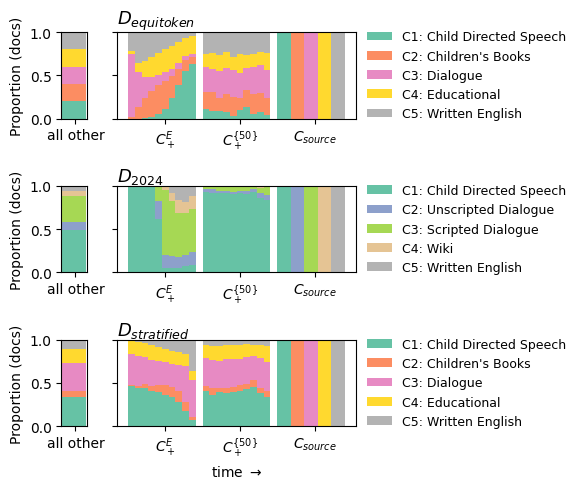

llama document_lenght
1
3
1
3
1
3


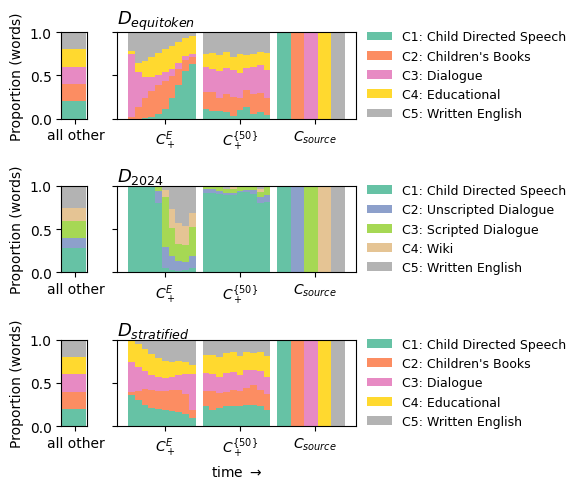

roberta counts
1
1
1
3


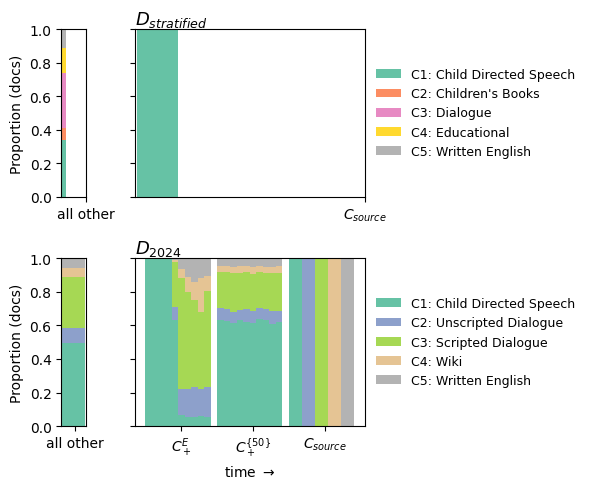

roberta document_lenght
1
1
1
3


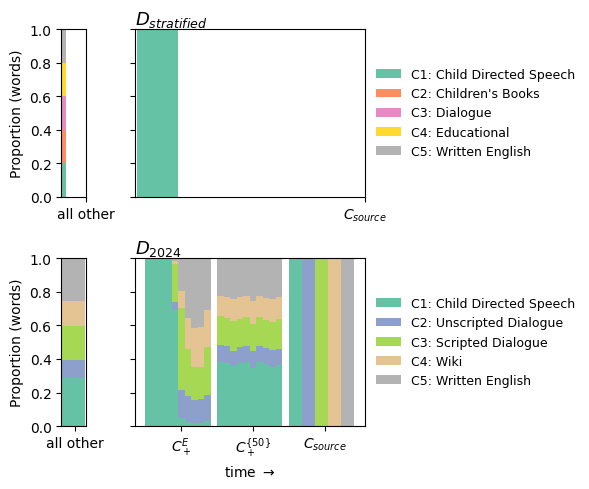

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import util
from sklearn.metrics.pairwise import cosine_similarity


def plot_proportions(model_type, value_column="document_lenght", skip_redundant = True):
    save_path = os.path.join("./autogenerated_figures", "source_proportions",value_column,f"{model_type}.pdf")

    ylabel_map = {
        "counts": "Proportion (docs)",
        "document_lenght": "Proportion (words)"
    }


    norm_df = stats_df[stats_df["model_type"] == model_type].copy()

    datasets = norm_df['dataset_name'].unique()
    stages = sorted(norm_df['stage'].unique())
    left_group = ['random.pt']

    norm_df['curriculum_group'] = norm_df['curriculum_name'].apply(
        lambda x: 'left' if x in left_group else 'right'
    )

    fig, axes = plt.subplots(
        len(datasets), 2,
        figsize=(6, 5),
        sharey=True,
        gridspec_kw={'width_ratios': [1.2, len(norm_df[norm_df["curriculum_group"] != "left"]["curriculum_name"].unique())]}
    )

    palette = sns.color_palette("Set2")

    if len(datasets) == 1:
        axes = [axes]


    for row_idx, dataset in enumerate(datasets):
        axes[row_idx][1].set_title(util.rename_dataset(dataset), loc='left', fontsize=13, pad=2,fontweight='bold')

        random_df = None

        
        data = norm_df[norm_df['dataset_name'] == dataset]

        for col_idx, group in enumerate(['left', 'right']):
            ax = axes[row_idx][col_idx]
            group_data = data[data['curriculum_group'] == group]

            pivot_df = group_data.pivot_table(
                index=['curriculum_name', 'epoch'],
                columns='stage',
                values=value_column,
                fill_value=0
            )

            try:
                random_df = pivot_df.loc["random.pt"]
            except:
                pass


            pivot_df = pivot_df.apply(lambda row: row / row.sum(), axis=1)
            if skip_redundant and "random.pt" not in pivot_df.index.get_level_values(0):
            
                for c in pivot_df.index.get_level_values(0).unique():
            
                    
            
                    if c != "random.pt":
                        pivot_vector = pivot_df.loc[c].values.reshape(1, -1)
                        random_vector = random_df.values.reshape(1, -1)
                        cos_sim = cosine_similarity(pivot_vector, random_vector)[0][0]

                        if cos_sim  > 0.999:
            
                            pivot_df = pivot_df.drop(labels=c, level=0, axis=0)
                            


            bottom = pd.Series([0] * len(pivot_df), index=pivot_df.index)
            for ii, stage in enumerate(stages):
                if stage in pivot_df:
                    vals = pivot_df[stage]
                    x_positions = []
                    padding = 1
                    for i in range(len(pivot_df)):
                        pad = (i // 10) * padding
                        x_positions.append(i + pad)

                    ax.bar(x_positions, vals, bottom=bottom, label=stage, width=1.0, color=palette[ii])
                    bottom += vals

            if col_idx == 0:
                ax.set_ylabel(ylabel_map[value_column])
            else:
                ax.set_ylabel("")
                ax.tick_params(labelleft=False)
            ax.set_ylim(0, 1)

            n_curricula = len(pivot_df.index.get_level_values(0).unique())
            print(n_curricula)
            ax.set_xticks([x + i * 11 for i in range(n_curricula) for x in [5]])
            rename_ = lambda x : util.rename(x) if x != "random.pt" else "all other"

            ax.set_xticklabels([rename_(pivot_df.iloc[i*10].name[0]) for i in range(n_curricula)], rotation=0)
            
        
        a = axes[row_idx][1]
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = []
        unique_handles = []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handle)
        sorted_labels_handles = sorted(zip(unique_labels, unique_handles))
        sorted_labels, sorted_handles = zip(*sorted_labels_handles)

        a.legend(
                handles=unique_handles,
                labels=unique_labels,
                bbox_to_anchor=(1.00, 0.5),
                loc='center left',
                ncol=1,
                fontsize=9,
                frameon=False
            )
        
    axes[-1][1].set_xlabel(f"time $\\rightarrow$")


    plt.tight_layout()
    plt.rcParams.update({
        "text.usetex": False,         
    })
    os.makedirs(os.path.dirname(save_path),exist_ok=True)
    plt.savefig(save_path, dpi=600,bbox_inches='tight') 
    plt.show()
    
from itertools import product

for model_type, value_column in product(config.model_types, ["counts", "document_lenght"]):
    print(model_type, value_column)
    plot_proportions(model_type, value_column,skip_redundant=True)